 TODO

- [ ] Fix members to take sheetnrs into account

In [4]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
import io
import tarfile
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy import sparse
import time
from tqdm import tqdm

In [6]:
from xlrd.compdoc import CompDocError
import xlrd

In [7]:
# Suppress warning for xlrd
import warnings
# Filter all warning that start with "WARNING"
warnings.filterwarnings('ignore')

In [107]:
# pass over all files and build summary
file = '/Users/dirkocoetsee/Downloads/fuse-binaries-dec2014.tar.gz'
# Get list of files in tar archive
tar = tarfile.open(file)

In [61]:
all_members = tar.getmembers()
len(all_members)

249377

In [26]:
#tar.extractfile(all_members[1])
#all_members[1].name

In [9]:
#for i, member in enumerate(all_members):
#    if i > 10:
#        break
#    if member.name == 'cc-binaries':
#        continue
#    print(member.name)
#    buffer = tar.extractfile(member)
#    # Read the excel file in the buffer
#    try:
#        df = pd.read_excel(io.BytesIO(buffer.read()))
#    except CompDocError:
#        print('  CompDocError')
#        continue
#    print('  ', df.shape)

In [19]:
def load_from_tar(tar, total_length):
    vocab = {}
    words_member = []
    words = []
    t0 = time.time()
    total_time_open = 0
    for icounter, member in enumerate(tar):
        #print(i, member.name, member.isfile())
        t0_loop = time.time()
        if icounter > 1_000_000:
            break
        #print(member.name)
        #buffer = tar.extractfile(member)
        if not member.isfile():
            continue
        try:
            buffer = tar.extractfile(member)
            dfs = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=None, header=None, index_col=None, nrows=100)
            #df = pd.read_excel(buffer, header=None, index_col=None)
        except CompDocError:
            continue
        except AttributeError:
            continue
        except IndexError:
            continue
        except Exception as e:
            #print('Other', e)
            continue
        # Iterate over all cells
        vals = {str(v)[:20] for df in dfs.values() for v in df.values[:100, :100].flatten()}
        t1 = time.time()
        # Update vocab
        vocab_size = len(vocab)
        # Add new words to vocab
        vocab.update({v: vocab_size+i for i, v in enumerate(val[:20] if isinstance(val, str) else val for val in vals if val not in vocab)})
        # Update words
        words.append({vocab[v[:20] if isinstance(v, str) else v] for v in vals})
        words_member.append(member)
        t2 = time.time()
        total_time_open += t1 - t0_loop
        total_time = (t2 - t0)
        percentage_open = total_time_open / total_time
        items_per_second = icounter / (t2 - t0)
        if icounter % 100 == 0:
            print(f'{icounter} /  {total_length}', f'{items_per_second:.1f}', f'{percentage_open:.2%}', member.name, '  ', len(dfs), list(dfs.values())[0].shape, len(vals), len(vocab))
    return vocab, words_member, words


In [102]:
file = '/Users/dirkocoetsee/Downloads/fuse-binaries-dec2014.tar.gz'
#with open(file, 'rb') as f:
tar_stream = tarfile.open(file, mode='r|*')
vocab, words_member, words =  load_from_tar(tar_stream, 249377)

In [106]:
print(tar_stream.tarinfo.)

<class 'tarfile.TarInfo'>


In [22]:
1+1

2

In [24]:
def pack(words_member, words):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for name, sheet in tqdm(zip(words_member, words)):
        indices.extend(list(sheet))
        #for index in sheet:
        #    indices.append(index)
        #    data.append(1)
        data.extend([1] * len(sheet))
        indptr.append(len(indices))
    x = csr_matrix((data, indices, indptr), dtype=int)
    return x

x = pack(words_member, words)
x.shape

161321it [00:04, 34392.09it/s]


(161321, 8591565)

In [3]:
# Load from disk
from scipy.sparse import load_npz
x = load_npz('data.npz')

In [4]:
from pickle import load
print('Loading')
with open('meta.pkl', 'rb') as f:
    vocab, words_member = load(f)
print('Adding')
words_member = ['cc-binaries/' + m for m in words_member]
len(words_member), len(vocab)

Loading
Adding


(65017, 50387672)

In [25]:
# Save to disk
def save(x, vocab, words_member):
    from scipy.sparse import save_npz
    from pickle import dump
    print('Saving data')
    save_npz('data.npz', x)
    # Save the vocab
    print('Saving meta')
    with open('meta.pkl', 'wb') as f:
        dump((vocab, [w.name.split('/')[-1] for w in words_member]), f)
    print('Done')
save(x, vocab, words_member)

Saving data
Saving meta
Done


In [28]:
!ls -lah data.npz meta.pkl

-rw-r--r--@ 1 dirkocoetsee  staff    87M Feb 13 12:55 data.npz
-rw-r--r--@ 1 dirkocoetsee  staff   184M Feb 13 12:56 meta.pkl


In [29]:
#max(v for k, v in vocab.items()), len(vocab)

In [30]:
x.shape

(161321, 8591565)

In [75]:
# Drop unique columns
lim = x.shape[0]
cols = np.where(x[:lim, :].sum(axis=0) > 1)[0]
xd = x[:lim, cols]

In [32]:
xd.shape

(161321, 3106136)

In [33]:
x[:10, :].sum(axis=1)[:5]

matrix([[885],
        [359],
        [160],
        [162],
        [200]])

In [76]:
# Get boolean tfidf
print('convert')
xdc = xd.tocsc()
print('sum')
N = xdc.shape[1]
idf = np.log(N / xdc.sum(axis=0))
print('divide')
xd = xd.multiply(idf)
print('done')

convert
sum
divide
done


In [77]:
r = np.dot(xd, xd.T)
r.shape, r.format

((161321, 161321), 'csr')

In [78]:
r[:5, :5].todense()

matrix([[5.14446648e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]])

In [79]:
# Set diagonal to -1
#rr = r.copy()
#n = r.shape[0]
#rr = rr * sparse.identity(n=n, format='csr') + (sparse.identity(n=n, format='csr') * -1)

# Dense
#rd = np.asarray(r.todense())
#rr = rd.copy()
#np.fill_diagonal(rr, -1)

# Sparse
rd = r
rr = rd.copy()
rr.setdiag(-1)

In [80]:
rr.shape

(161321, 161321)

In [39]:
#from multiprocessing import Pool
#k = 20
#
#def _top_k(args):
#    """
#    Helper function to process a single row of top_k
#    """
#    data, row = args
#    data, row = zip(*sorted(zip(data, row), reverse=True)[:k])
#    return data, row
#def top_k(m, k):
#    """
#    Keep only the top k elements of each row in a csr_matrix
#    """
#    ml = m.tolil()
#    #with Pool() as p:
#    #    ms = p.map(_top_k, zip(ml.data, ml.rows))
#    ms = [_top_k((d, r)) for d, r in zip(ml.data, ml.rows)]
#    ml.data, ml.rows = zip(*ms)
#    return ml.tocsr()

In [81]:
ml = rr.tolil()

In [82]:
ml.data.shape, ml.rows.shape, ml.data[:10], ml.rows[:10]

((161321,),
 (161321,),
 array([list([-1.0, 514446647.61200386, 514446647.61200386, 514446647.61200386, 514446647.61200386, 514446647.61200386, 514446647.61200386, 514446647.61200386]),
        list([-1.0]), list([-1.0]), list([-1.0]), list([-1.0]),
        list([-1.0]), list([-1.0]), list([-1.0]), list([-1.0]),
        list([-1.0])], dtype=object),
 array([list([0, 49675, 52714, 55604, 66491, 66877, 92117, 110078]),
        list([1]), list([2]), list([3]), list([4]), list([5]), list([6]),
        list([7]), list([8]), list([9])], dtype=object))

In [83]:
#from tqdm import tqdm
#import scipy.sparse

In [84]:
type(ml.data[0])

list

In [85]:
k = 20
ndats, nrows = [], []
for i, (row, dat) in (enumerate(zip(tqdm(ml.rows), ml.data))):
    ndat, nrow = zip(*sorted(zip(dat, row), reverse=True)[:k])
    #ndats.append(ndat)
    #nrows.append(nrow)
    ml.data[i] = list(nrow)
    ml.rows[i] = list(range(20))
tnrows = ml.shape[0]
#ml.shape = (tnrows, 20)
stop = ml.tocsr()
stop.shape

100%|██████████| 161321/161321 [00:00<00:00, 917619.01it/s] 


(161321, 161321)

In [92]:
stop.dtype

dtype('float64')

In [93]:
top = stop[:, :20].astype('int32').todense()

In [94]:
# Get indices of top 20 per row (excluding self)
#top = np.argsort(rr, axis=1)[:, -20:]
#top = top_k(rr, 20)
top.shape

(161321, 20)

In [95]:
top[:10, :20]

matrix([[110078,  92117,  66877,  66491,  55604,  52714,  49675,      0,
              1,      2,      3,      4,      5,      6,      7,      8,
              9,     10,     11,     12],
        [    13,     14,     15,     16,     17,     18,     19,     20,
             21,     22,     23,     24,     25,     26,     27,     28,
             29,     30,     31,     32],
        [    33,     34,     35,     36,     37,     38,     39,     40,
             41,     42,     43,     44,     45,     46,     47,     48,
             49,     50,     51,     52],
        [    53,     54,     55,     56,     57,     58,     59,     60,
             61,     62,     63,     64,     65,     66,     67,     68,
             69,     70,     71,     72],
        [    73,     74,     75,     76,     77,     78,     79,     80,
             81,     82,     83,     84,     85,     86,     87,     88,
             89,     90,     91,     92],
        [    93,     94,     95,     96,     97,     98,    

In [22]:
## Get r[i, j] for all i, j in top per row
##from numba import jit
##@jit(nopython=True)
#def construct_t(n, rd, top):
#    t = np.zeros((len(words_member), 20, 20))
#    for i in tqdm(range(len(words_member))):
#        for j in range(20):
#            for k in range(20):
#                t[i, j, k] = rd[top[i, j], top[i, k]]
#    return t
#t = construct_t(len(words_member), rd, top)

100%|██████████| 65017/65017 [03:38<00:00, 298.00it/s]


In [23]:
## Ravel along last two axes, leaving first axis
#ind = np.unravel_index(np.argsort(t.reshape((len(words_member), -1)), axis=1)[:, :10], (20, 20))
#ind[0].shape, ind[1].shape

((65017, 10), (65017, 10))

In [24]:
#ind[0]

array([[ 9, 14, 14, ..., 14, 14, 14],
       [ 0, 13, 13, ..., 13, 13, 13],
       [ 0, 13, 13, ..., 13, 13, 13],
       ...,
       [ 0, 13, 13, ..., 13, 13, 13],
       [ 0, 13, 13, ..., 13, 13, 13],
       [ 0, 13, 13, ..., 13, 13, 13]])

In [25]:
#ind[0][:, 0].shape

(65017,)

In [26]:
## Get all indices from top that correspond to ind[0]
#np.take_along_axis(top, ind[0], axis=1)[:10, :10]

matrix([[17969,     2,     2,     2,     2,     2,     2,     2,     2,
             2],
        [    8,    21,    21,    21,    21,    21,    21,    21,    21,
            21],
        [   28,    41,    41,    41,    41,    41,    41,    41,    41,
            41],
        [   48,    61,    61,    61,    61,    61,    61,    61,    61,
            61],
        [   68,    81,    81,    81,    81,    81,    81,    81,    81,
            81],
        [   88,   101,   101,   101,   101,   101,   101,   101,   101,
           101],
        [  108,   121,   121,   121,   121,   121,   121,   121,   121,
           121],
        [  128,   141,   141,   141,   141,   141,   141,   141,   141,
           141],
        [  148,   161,   161,   161,   161,   161,   161,   161,   161,
           161],
        [  168,   181,   181,   181,   181,   181,   181,   181,   181,
           181]])

In [69]:
#next(index_name_mapn.items())
# not an iterator? Show first pair
#isinstance(next(iter(index_name_mapn.items()))[1], tarfile.TarInfo)
words_member[0]

<TarInfo 'cc-binaries/25401149-02fa-402e-94f4-c660bcf386b6' at 0x11fd01900>

In [70]:
#i0 = np.take_along_axis(top, ind[0], axis=1)
#i1 = np.take_along_axis(top, ind[1], axis=1)
if isinstance(words_member[0], tarfile.TarInfo):
    index_name_map = {i: k for i, k in enumerate(words_member)}
else:
    ## Map back to filenames
    index_name_mapn = {i: k for i, k in enumerate(words_member)}
    ## Map back to members
    member_name_map = {member.name: member for member in all_members}
    index_name_map = {i: member_name_map[k] for i, k in index_name_mapn.items()}
#
## Get filenames for the first tripple
#f1 = (index_name_map[0])
#f2 = (index_name_map[i0[0,0]])
#f3 = (index_name_map[i1[0,0]])
#print(f1, f2, f3)

In [29]:
#rd[ic1, ic2], ic1, ic2, i0[ir, :].shape
#(x[ic1, :].multiply( x[ic2, :])).multiply(  x[ir, :]).shape
#allthree = (x[ic1, :] * x[ic2, :] * x[ir, :]).sum()
#np.array(i0[ir, :]).flatten()
#allthree.item(),allthree

NameError: name 'allthree' is not defined

In [31]:
#x.shape, i0.shape, i1.shape

((65017, 50387711), (65017, 10), (65017, 10))

In [49]:
x_lil = x.tolil()
x_lil.shape

(161321, 8591565)

In [50]:
x_lil.data.shape, x_lil.rows.shape

((161321,), (161321,))

In [51]:
x_lil.rows[:1]

array([list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [52]:
x_set = [
    set(row)
    for row in x_lil.rows
]
len(x_set)

161321

In [96]:
topa = np.array(top)
topa.shape

(161321, 20)

In [97]:
topa[:10, :10]

array([[110078,  92117,  66877,  66491,  55604,  52714,  49675,      0,
             1,      2],
       [    13,     14,     15,     16,     17,     18,     19,     20,
            21,     22],
       [    33,     34,     35,     36,     37,     38,     39,     40,
            41,     42],
       [    53,     54,     55,     56,     57,     58,     59,     60,
            61,     62],
       [    73,     74,     75,     76,     77,     78,     79,     80,
            81,     82],
       [    93,     94,     95,     96,     97,     98,     99,    100,
           101,    102],
       [   113,    114,    115,    116,    117,    118,    119,    120,
           121,    122],
       [   133,    134,    135,    136,    137,    138,    139,    140,
           141,    142],
       [   153,    154,    155,    156,    157,    158,    159,    160,
           161,    162],
       [   173,    174,    175,    176,    177,    178,    179,    180,
           181,    182]], dtype=int32)

In [98]:
scores = []
for i, xs in enumerate(tqdm(x_set)):
    for j in range(20):
        for k in range(20):
            if k >= j:
                continue
            j_ind = topa[i, j]
            k_ind = topa[i, k]
            sa1 = x_set[i] & x_set[j_ind]
            sa2 = x_set[i] & x_set[k_ind]
            inter = (sa1 & sa2)
            intern = len(inter)
            sa1i = len(sa1 - inter)
            sa2i = len(sa2 - inter)
            denom1 = len(x_set[j_ind])
            denom2 = len(x_set[k_ind])
            denom = len(x_set[i])
            scores.append((i, j_ind, k_ind, sa1i, sa2i, intern, denom, denom1, denom2))


100%|██████████| 161321/161321 [03:16<00:00, 821.74it/s] 


In [52]:
#n = len(words_member)
#alltm = np.zeros((n, 20, 20))
#for i in tqdm(range(n)):
#    subx = x[top[i, :].A1, :]
#    subxm = x[i].multiply(subx)
#    #alltm[i] = (subxm @ subxm.T).toarray()
##top[0, :].A1.shape

  0%|          | 112/65017 [00:15<2:33:08,  7.06it/s]


KeyboardInterrupt: 

In [99]:
## Get score for each tripple
#tripples = []
#sums = np.array(rd.sum(axis=1))
#rd_lookup = rd.todok()
#for ir in tqdm(range(len(words_member))):
#    #fl1 = np.array(i0[ir, :]).flatten()
#    #fl2 = np.array(i1[ir, :]).flatten()
#    #for ic1, ic2 in zip(fl1, fl2):
#    for jr in range(i0.shape[1]):
#        t0 = time.time()
#        ic1 = i0[ir, jr]
#        ic2 = i1[ir, jr]
#        t1 = time.time()
#        alpha1 = rd_lookup[ir, ic1]
#        #alphan1 = (alpha1 / sums[ir]).item()
#        alpha2 = rd_lookup[ir, ic2]
#        #alphan2 = (alpha2 / sums[ir]).item()
#        #score = alpha1 + alpha2 - r[ic1, ic2] / max(sums[ic1], sums[ic2])
#        beta = rd_lookup[ic1, ic2]
#        t2 = time.time()
#        #score = alpha1 + alpha2 - rd[ic1, ic2] / sums[ir]
#        #score = (alpha1 * alpha2 - (rd[ic1, ic2] + 1)) / (sums[ir] + 1) ** 1
#        #score = alphan1 * alphan2
#        allthree = (x[ic1, :].multiply( x[ic2, :])).multiply(  x[ir, :]).sum()
#        t3 = time.time()
#        score = ((alpha1 + alpha2 - allthree) / sums[ir]).item()
#        t4 = time.time()
#        #tripples.append((ir, ic1.item(), ic2.item(), score, alphan1, alphan2, alpha1, alpha2, beta, allthree))
#        tripples.append((ir, ic1.item(), ic2.item(), score, alpha1, alpha2, beta, allthree))
#        t5 = time.time()
#        if ir < 2:
#            #print(ir, ic1, ic2, score, alphan1, alphan2, alpha1, alpha2, beta, alpha1 + alpha2 - beta)
#            #print(ir, ic1, ic2, f'{score:.3f}', f'{alphan1:.3f}', f'{alphan2:.3f}', f'{alpha1:>4}', f'{alpha2:>4}', f'{beta:>4}', f'{alpha1 + alpha2 - beta:>4}')
#            print(ir, ic1, ic2, f'{score:.3f}', f'{alpha1:>4}', f'{alpha2:>4}', f'{beta:>4}', f'{alpha1 + alpha2 - beta:>4}')
#            print(t1-t0, t2-t1, t3-t2, t4-t3, t5-t4)
#len(tripples)


  0%|          | 0/65017 [00:00<?, ?it/s]

0 12 12 -0.000    0    0    0    0
9.202957153320312e-05 0.00011181831359863281 0.5139200687408447 5.412101745605469e-05 6.9141387939453125e-06
0 1 3 -0.000    0    0    0    0
3.814697265625e-06 4.410743713378906e-05 0.35233306884765625 2.4080276489257812e-05 9.059906005859375e-06
0 1 4 -0.000    0    0    0    0
5.9604644775390625e-06 8.0108642578125e-05 0.2877519130706787 1.1920928955078125e-05 1.3113021850585938e-05
0 1 5 -0.000    0    0    0    0
1.9073486328125e-06 3.0994415283203125e-05 0.16812419891357422 1.5735626220703125e-05 1.1205673217773438e-05
0 1 6 -0.000    0    0    0    0
4.76837158203125e-06 5.316734313964844e-05 0.35616493225097656 2.4080276489257812e-05 6.9141387939453125e-06
0 1 7 -0.000    0    0    0    0
2.574920654296875e-05 6.103515625e-05 0.27240800857543945 2.2172927856445312e-05 1.0967254638671875e-05
0 1 8 -0.000    0    0    0    0
4.291534423828125e-06 4.076957702636719e-05 0.3824462890625 1.7881393432617188e-05 1.3828277587890625e-05
0 1 9 -0.000    

  0%|          | 1/65017 [00:03<60:19:02,  3.34s/it]

0 1 11 -0.000    0    0    0    0
1.2636184692382812e-05 5.125999450683594e-05 0.23017287254333496 1.5020370483398438e-05 1.2874603271484375e-05
1 0 0 -inf    0    0 4417647 -4417647
9.059906005859375e-06 8.606910705566406e-05 0.04548501968383789 0.0025300979614257812 1.5735626220703125e-05
1 0 0 -inf    0    0 4417647 -4417647
1.5974044799804688e-05 0.00010800361633300781 0.06505703926086426 2.002716064453125e-05 1.4066696166992188e-05
1 0 0 -inf    0    0 4417647 -4417647
7.867813110351562e-06 4.696846008300781e-05 0.08637189865112305 2.002716064453125e-05 3.0994415283203125e-06


/var/folders/l0/myzlkgcx3279pbd97y6m09nh0000gn/T/ipykernel_42748/1446533083.py:26: RuntimeWarning: divide by zero encountered in divide
  score = ((alpha1 + alpha2 - allthree) / sums[ir]).item()


1 0 0 -inf    0    0 4417647 -4417647
3.0994415283203125e-06 3.981590270996094e-05 0.0962519645690918 3.2901763916015625e-05 9.059906005859375e-06
1 0 0 -inf    0    0 4417647 -4417647
7.867813110351562e-06 7.82012939453125e-05 0.05318498611450195 3.886222839355469e-05 1.9073486328125e-05
1 0 0 -inf    0    0 4417647 -4417647
5.9604644775390625e-06 8.511543273925781e-05 0.07743287086486816 2.5033950805664062e-05 4.76837158203125e-06
1 0 0 -inf    0    0 4417647 -4417647
4.0531158447265625e-06 4.57763671875e-05 0.10130715370178223 4.1961669921875e-05 0.002547025680541992
1 0 0 -inf    0    0 4417647 -4417647
1.0967254638671875e-05 9.5367431640625e-05 0.07227492332458496 2.3126602172851562e-05 4.76837158203125e-06
1 0 0 -inf    0    0 4417647 -4417647
4.0531158447265625e-06 4.410743713378906e-05 0.06297993659973145 2.288818359375e-05 5.245208740234375e-06
1 0 0 -inf    0    0 4417647 -4417647
3.0994415283203125e-06 4.315376281738281e-05 0.06882476806640625 2.193450927734375e-05 3.0994415

  0%|          | 6/65017 [00:13<40:22:49,  2.24s/it]


KeyboardInterrupt: 

In [55]:
len(tripples)

NameError: name 'tripples' is not defined

In [103]:
#sa1i = 20
#denom = 200
#sa2i = 10
#np.sqrt((sa1i / (denom*0.5 + 1)) * (sa2i / (denom*0.5 + 1)))

np.float64(0.14002114478941535)

In [99]:
ftripples = [(i, j, k,
              np.sqrt((sa1i / (denom + 10)) * (sa2i / (denom + 10))),  # Geometric mean of areas
              #np.sqrt((sa1i / (1)) * (sa2i / (1))),  # Geometric mean of nums
              #np.sqrt((sa1i / (1)) * (sa2i / (1))) / (denom + 10),  # Geometric mean of nums
              #(sa1i + sa2i + intern) / (denom + 10),                 # Percentage area
              sa1i, sa2i, intern, denom, denom1, denom2) for i ,j, k, sa1i, sa2i, intern, denom, denom1, denom2 in scores]
ftripples = sorted(ftripples, key=lambda x: x[3], reverse=True)
for i, j, k, score, *rest in ftripples[:20]:
    print(i, j, k, score, rest)

3814 76257 76255 0.34158239604210705 [57, 92, 12, 202, 2234, 205]
4383 87636 87623 0.3367131766858274 [55, 80, 15, 187, 208, 396]
4 88 83 0.33665016461206926 [102, 49, 9, 200, 204, 4119]
7408 148112 148110 0.3341011710031337 [57, 76, 14, 187, 208, 6430]
4383 87636 87633 0.32897160905623657 [56, 75, 14, 187, 208, 347]
4829 96540 96534 0.32854053046262754 [71, 59, 6, 187, 161, 205]
6808 136120 136108 0.32677110536915904 [56, 74, 16, 187, 217, 525]
4829 96540 96532 0.3257443899925776 [71, 58, 6, 187, 161, 206]
4383 87636 87627 0.3230437071410623 [54, 75, 16, 187, 208, 635]
7408 148112 148105 0.32232503282005165 [56, 72, 15, 187, 208, 316]
6808 136111 136108 0.32216510969791734 [53, 76, 14, 187, 210, 525]
4638 92722 92718 0.31661497665069294 [50, 81, 15, 191, 217, 536]
1313 26266 26260 0.31579085781211597 [79, 48, 8, 185, 1230, 208]
4638 92722 92720 0.3114920565671349 [49, 80, 16, 191, 217, 3303]
4829 96538 96534 0.3045685279187817 [72, 50, 15, 187, 583, 205]
1299 25988 25987 0.30421591489

In [105]:
#dft = pd.DataFrame(ftripples, columns = ['i', 'j', 'k', 'score', 'sa1i', 'sa2i', 'intern', 'denom', 'denom1', 'denom2'])
#dft.shape

(12353230, 10)

<Axes: xlabel='sa1in', ylabel='sa2in'>

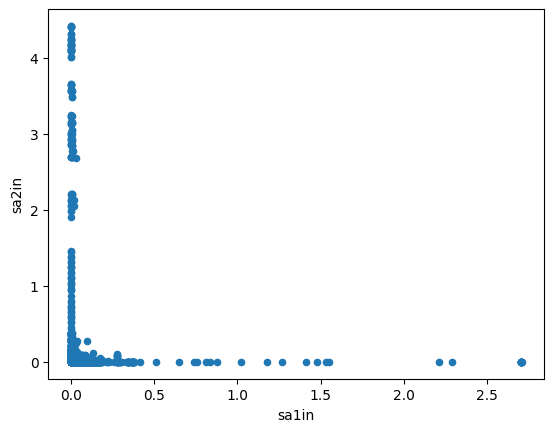

In [110]:
#dft['sa1in'] = dft['sa1i'] / denom
#dft['sa2in'] = dft['sa2i'] / denom
#dft.head(10000).plot.scatter(x='sa1in', y='sa2in')

In [262]:
## Filter out tripples with low alpha1 or alpha2
#threshold = 0.02
#ftripples = [t for t in tripples if t[4] > threshold and t[5] > threshold]
#print(len(tripples), len(ftripples))

7364 10


In [263]:
#for i, j, k, s, an1, an2, a1, a2, b in sorted(ftripples, key=lambda x: x[3], reverse=True)[:20]:
#    print(i, j, k, f'{s:.3f}', f'{an1:.3f}', f'{an2:.3f}', f'{a1:>4}', f'{a2:>4}', f'{b:>4}')

199 5379 6075 0.042 0.021 0.021  267  256    2
199 5379 5868 0.042 0.021 0.021  267  256    2
199 5379 5434 0.042 0.021 0.021  267  256    2
199 5379 2503 0.042 0.021 0.021  267  256    2
199 5379 5652 0.042 0.021 0.021  267  256    2
199 5379 5157 0.042 0.021 0.021  267  256    2
199 5379 4039 0.042 0.021 0.021  267  256    2
199 5379 3310 0.042 0.021 0.021  267  256    2
199 5379 1453 0.042 0.021 0.021  267  256    2
199 3310 5379 0.042 0.021 0.021  256  267    2


In [100]:
# Load and display
for if1, if2, if3, score, *als in ftripples[:4]:
    f1 = (index_name_map[if1])
    f2 = (index_name_map[if2])
    f3 = (index_name_map[if3])
    for i, f in enumerate([f1, f2, f3]):
        buffer = tar.extractfile(f)
        df = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=None, header=None, index_col=None, nrows=10)
        print(f'File {i} ({score}): {f}  {als}')
        print()
        # Display as html
        display(df)
        print()


File 0 (0.34158239604210705): <TarInfo 'cc-binaries/fbb78d42-0904-4190-a5f5-e0154e1dab6a' at 0x28726e200>  [57, 92, 12, 202, 2234, 205]



,Abbotsford Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,1,Peoria,1,Abbotsford,4,Final,Abbotsford Entertainment & Sports Centre Abbot...
2,2012-10-13,8,Peoria,2,Abbotsford,6,Final,Abbotsford Entertainment & Sports Centre Abbot...
3,2012-10-19,30,Chicago,3,Abbotsford,2,Final SO,Abbotsford Entertainment & Sports Centre Abbot...
4,2012-10-20,44,Chicago,1,Abbotsford,4,Final,Abbotsford Entertainment & Sports Centre Abbot...
...,...,...,...,...,...,...,...,...
72,2013-04-06,1030,Grand Rapids,2,Abbotsford,3,Final SO,Abbotsford Entertainment & Sports Centre Abbot...
73,2013-04-12,1062,Toronto,0,Abbotsford,3,Final,Abbotsford Entertainment & Sports Centre Abbot...
74,2013-04-14,1086,Toronto,1,Abbotsford,3,Final,Abbotsford Entertainment & Sports Centre Abbot...
75,2013-04-19,1108,Abbotsford,0,Oklahoma City,1,Final,"Cox Convention Center Oklahoma City, OK"



File 1 (0.34158239604210705): <TarInfo 'cc-binaries/073e9337-93cf-4f58-ad13-16dd5eac27d2' at 0x2f4ee04c0>  [57, 92, 12, 202, 2234, 205]



,Unnamed: 0,BELKNAP COUNTY OFFICES,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,2008-11-04 00:00:00,Sheriff,NaN,,Attorney,NaN,NaN,Treasurer,NaN
1,NaN,"Wiggin, r&d",Others,NaN,"Carroll, d&r",Others,NaN,"Muzzey, r",Others
2,Alton,2707,NaN,NaN,2687,NaN,NaN,2177,NaN
3,Barnstead,2011,NaN,NaN,1989,NaN,NaN,1445,NaN
4,Belmont,2987,11,NaN,3035,1,NaN,2235,8
5,Center Harbor,653,1,NaN,663,NaN,NaN,412,NaN
6,Gilford,3850,13,NaN,3916,3,NaN,2937,12
7,Gilmanton,1843,2,NaN,1847,1,NaN,1344,1
8,Laconia Ward 1,1403,3,NaN,1415,NaN,NaN,1065,1
9,Laconia Ward 2,1093,4,NaN,1148,3,NaN,802,1



File 2 (0.34158239604210705): <TarInfo 'cc-binaries/d3d6dfcc-d231-4272-87d1-34976d2f4901' at 0x2f4ee0400>  [57, 92, 12, 202, 2234, 205]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-13,13,Rockford,0,Chicago,1,Final SO,"Allstate Arena Rosemont, IL"
2,2012-10-14,22,Rockford,3,Chicago,5,Final,"Allstate Arena Rosemont, IL"
3,2012-10-19,39,Rockford,1,Peoria,2,Final,"Carver Arena Peoria, IL"
4,2012-10-20,50,Charlotte,2,Rockford,1,Final,"BMO Harris Bank Center Rockford, IL"
...,...,...,...,...,...,...,...,...
72,2013-04-10,1058,Rockford,0,Peoria,4,Final,"Carver Arena Peoria, IL"
73,2013-04-12,1071,Chicago,3,Rockford,7,Final,"BMO Harris Bank Center Rockford, IL"
74,2013-04-13,1081,Rockford,3,Milwaukee,1,Final,"BMO Harris Bradley Center Milwaukee, WI"
75,2013-04-19,1112,Rockford,9,San Antonio,4,Final,"AT&T Center San Antonio, TX"



File 0 (0.3367131766858274): <TarInfo 'cc-binaries/b112e51a-cc85-4131-9bb9-45a6b680734d' at 0x2856bb1c0>  [55, 80, 15, 187, 208, 396]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,3,Milwaukee,3,Grand Rapids,2,Final,"Van Andel Arena Grand Rapids, MI"
2,2012-10-12,6,Manchester,3,Providence,1,Final,"Dunkin' Donuts Center Providence, RI"
3,2012-10-12,7,Syracuse,5,Rochester,6,Final SO,"Blue Cross Arena Rochester, NY"
4,2012-10-12,2,Bridgeport,6,Connecticut,4,Final,"XL Center Hartford, CT"
...,...,...,...,...,...,...,...,...
1136,2013-04-21,1138,Norfolk,3,Providence,4,Final,"Dunkin' Donuts Center Providence, RI"
1137,2013-04-21,1133,Grand Rapids,3,Chicago,1,Final,"Allstate Arena Rosemont, IL"
1138,2013-04-21,1135,Manchester,2,Hershey,4,Final,"Giant Center Hershey, PA"
1139,2013-04-21,1136,Houston,0,Oklahoma City,3,Final,"Cox Convention Center Oklahoma City, OK"



File 1 (0.3367131766858274): <TarInfo 'cc-binaries/5aa3c071-74bf-4cb0-99b5-22030236b81f' at 0x2fbcdbb80>  [55, 80, 15, 187, 208, 396]



,Lake Erie Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,4,Oklahoma City,1,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"
2,2012-10-13,16,Oklahoma City,3,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"
3,2012-10-14,27,Lake Erie,4,Toronto,0,Final,"Ricoh Coliseum Toronto, ON"
4,2012-10-20,49,Lake Erie,5,Oklahoma City,3,Final,"Cox Convention Center Oklahoma City, OK"
...,...,...,...,...,...,...,...,...
72,2013-04-09,1054,Syracuse,4,Lake Erie,5,Final OT,"Quicken Loans Arena Cleveland, OH"
73,2013-04-12,1067,Lake Erie,6,Hamilton,2,Final,"Copps Coliseum Hamilton, ON"
74,2013-04-13,1079,Hamilton,2,Lake Erie,3,Final,"Quicken Loans Arena Cleveland, OH"
75,2013-04-19,1106,Chicago,5,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107663e20>>
Traceback (most recent call last):
  File "/Users/dirkocoetsee/Dropbox/research/phd2024/union/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


File 2 (0.3367131766858274): <TarInfo 'cc-binaries/15224944-6a95-4c9f-bdc4-3f4df6f5e2ab' at 0x2fbcd8280>  [55, 80, 15, 187, 208, 396]



,ليست قطعاتی که امکان مارک 500 را ندارند به تاریخ 1391/05/22,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,ردیف,سريال,نوع خودرو,شرح
1,1,100037,MNT,واشر سر سيلندر
2,2,100039,MNT,تيغه برف پاک کن جلو چپ
3,3,100040,MNT,تيغه برف پاک کن جلو راست
4,4,100043,MNT,مجموعه فن رادياتور
...,...,...,...,...
3208,3208,210169,LOG,فیلتر بنزین
3209,3209,210136,LOG,فیلتر هوا
3210,3210,230511,MEG,فیلتر روغن
3211,3211,225151,MEG,فیلتر هوای کابین



File 0 (0.33665016461206926): <TarInfo 'cc-binaries/617b82c1-f2c8-4cd4-98aa-a3d1d03cbb8f' at 0x11fd034c0>  [102, 49, 9, 200, 204, 4119]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,6,Manchester,3,Providence,1,Final,"Dunkin' Donuts Center Providence, RI"
2,2012-10-13,12,Providence,2,Bridgeport,4,Final,"Webster Bank Arena Bridgeport, CT"
3,2012-10-19,35,Providence,4,Manchester,3,Final,"Verizon Wireless Arena Manchester, NH"
4,2012-10-20,52,Providence,3,Springfield,1,Final,"MassMutual Center Springfield, MA"
...,...,...,...,...,...,...,...,...
72,2013-04-13,1082,Providence,2,Springfield,0,Final,"MassMutual Center Springfield, MA"
73,2013-04-14,1092,Norfolk,1,Providence,4,Final,"Dunkin' Donuts Center Providence, RI"
74,2013-04-19,1110,Springfield,3,Providence,5,Final,"Dunkin' Donuts Center Providence, RI"
75,2013-04-20,1119,Providence,3,Bridgeport,0,Final,"Webster Bank Arena Bridgeport, CT"



File 1 (0.33665016461206926): <TarInfo 'cc-binaries/73e88f66-14b1-480f-8f10-5f68bd864e98' at 0x11ffa3640>  [102, 49, 9, 200, 204, 4119]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,2,Bridgeport,6,Connecticut,4,Final,"XL Center Hartford, CT"
2,2012-10-14,23,St. John's,3,Connecticut,2,Final,"XL Center Hartford, CT"
3,2012-10-19,37,Connecticut,4,Norfolk,5,Final OT,"Norfolk Scope Norfolk, VA"
4,2012-10-20,48,Connecticut,3,Norfolk,6,Final,"Norfolk Scope Norfolk, VA"
...,...,...,...,...,...,...,...,...
72,2013-04-12,1068,Connecticut,1,Manchester,3,Final,"Verizon Wireless Arena Manchester, NH"
73,2013-04-13,1074,Connecticut,3,Adirondack,4,Final OT,"Glens Falls Civic Center Glens Falls, NY"
74,2013-04-14,1094,Connecticut,3,Springfield,4,Final,"MassMutual Center Springfield, MA"
75,2013-04-19,1102,Connecticut,2,Albany,3,Final,"Times Union Center Albany, NY"



File 2 (0.33665016461206926): <TarInfo 'cc-binaries/0fd5fb83-6dd5-4eb2-8e66-2a5f2563024d' at 0x11ff00d00>  [102, 49, 9, 200, 204, 4119]



,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,Time Series Workbook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"8731.0 Building Approvals, Australia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,TABLE 71. Value of Non-residential Building Ap...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
122,Value of Approval ; Western Australia ; Tota...,NaN,NaN,Original,A577687C,2000-07-01 00:00:00,2010-10-01 00:00:00,124,$'000,FLOW,Month,1
123,Value of Approval ; Western Australia ; Tota...,NaN,NaN,Original,A586066F,2000-07-01 00:00:00,2010-10-01 00:00:00,124,$'000,FLOW,Month,1
124,Value of Approval ($'000) ; Western Australia...,NaN,NaN,Original,A601301K,2000-07-01 00:00:00,2010-10-01 00:00:00,124,$'000,FLOW,Month,1
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



File 0 (0.3341011710031337): <TarInfo 'cc-binaries/7cc7a9f4-7884-4480-8722-7d1c54cca73c' at 0x28d250c40>  [57, 76, 14, 187, 208, 6430]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,3,Milwaukee,3,Grand Rapids,2,Final,"Van Andel Arena Grand Rapids, MI"
2,2012-10-12,6,Manchester,3,Providence,1,Final,"Dunkin' Donuts Center Providence, RI"
3,2012-10-12,7,Syracuse,5,Rochester,6,Final SO,"Blue Cross Arena Rochester, NY"
4,2012-10-12,2,Bridgeport,6,Connecticut,4,Final,"XL Center Hartford, CT"
...,...,...,...,...,...,...,...,...
1136,2013-04-21,1138,Norfolk,3,Providence,4,Final,"Dunkin' Donuts Center Providence, RI"
1137,2013-04-21,1133,Grand Rapids,3,Chicago,1,Final,"Allstate Arena Rosemont, IL"
1138,2013-04-21,1135,Manchester,2,Hershey,4,Final,"Giant Center Hershey, PA"
1139,2013-04-21,1136,Houston,0,Oklahoma City,3,Final,"Cox Convention Center Oklahoma City, OK"



File 1 (0.3341011710031337): <TarInfo 'cc-binaries/db3a7222-f892-470d-82c4-8f33acbe3917' at 0x35617c700>  [57, 76, 14, 187, 208, 6430]



,Season Schedule,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Date,Game Number,Visiting Team,Visiting Score,Home Team,Home Score,Game Time/Status,Venue
1,2012-10-12,4,Oklahoma City,1,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"
2,2012-10-13,16,Oklahoma City,3,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"
3,2012-10-14,27,Lake Erie,4,Toronto,0,Final,"Ricoh Coliseum Toronto, ON"
4,2012-10-20,49,Lake Erie,5,Oklahoma City,3,Final,"Cox Convention Center Oklahoma City, OK"
...,...,...,...,...,...,...,...,...
72,2013-04-09,1054,Syracuse,4,Lake Erie,5,Final OT,"Quicken Loans Arena Cleveland, OH"
73,2013-04-12,1067,Lake Erie,6,Hamilton,2,Final,"Copps Coliseum Hamilton, ON"
74,2013-04-13,1079,Hamilton,2,Lake Erie,3,Final,"Quicken Loans Arena Cleveland, OH"
75,2013-04-19,1106,Chicago,5,Lake Erie,2,Final,"Quicken Loans Arena Cleveland, OH"



File 2 (0.3341011710031337): <TarInfo 'cc-binaries/b58cd29e-ba88-4d5a-9b5d-ec4ae0e95116' at 0x34d081480>  [57, 76, 14, 187, 208, 6430]



,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,20,21,22,23,24,25,26,27,28,Unnamed: 43
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,21,22,23,24,25,26,27,28,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,第７－１表 貯蓄・純貯蓄・負債現在高階級，年間収入階級別１世帯当たり１か月間の収入と支出,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Table 7-1 Monthly Receipts and Disbursements ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,7014B,86*30,,,NaN,257.0,NaN,NaN,年間収入(万円),NaN,...,...,...,...,...,...,...,...,...,...,"Yearly income (in 10,000 yen)"
275,7014B,86*30,,,NaN,258.0,NaN,NaN,調整集計世帯数,NaN,...,804,8311,1950,937,1812,2176,944,452,2984,Adjusted num. of tabulated households
276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,注：1) 「住居」のほか，「自動車等購入」，「贈与金」，「仕送り金」を除いている。,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(a) (Regrouped) Consumption expenditures exclu...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## For each slice along axis=0, get the axis=1 and axis=2 combination with the lowest value
#for i in range(len(words)):
#    t[i, :, :]

In [ ]:
#t.shape